In [ ]:
import pandas as pd
import pvlib
import datetime
import os
import pathlib
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt

In [8]:
base_dir = os.path.join(pathlib.Path.home(), 'ecen5407', 'ecen5407_project2')
data_pt = os.path.join(base_dir, "data", "222628_32.73_-117.18_2012_interpolated.csv")

data = pd.read_csv(data_pt, skiprows=2)
data.set_index(pd.DatetimeIndex(data['Unnamed: 0']), inplace=True)

In [10]:
start_date = '2012-01-01 00:00:00'
end_date = '2012-12-31 23:55:00'

lat, lon = 32.73, -117.18
offset = 8

loc = pvlib.location.Location(lat,lon, altitude=0)
fake_index = pd.date_range(datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=-offset),
                           datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=offset), freq='5min')
solar_position = loc.get_solarposition(times=fake_index)
solar_position.set_index(solar_position.index.shift(periods=-offset, freq = '1h'), inplace = True)
solar_position = solar_position.loc[data.index]
data = pd.concat([data, solar_position], axis=1)

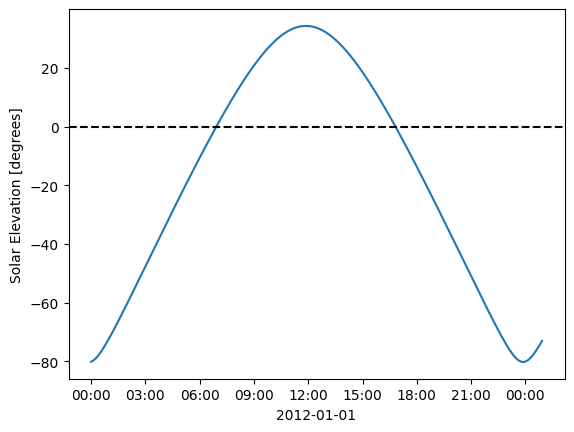

In [15]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = data.index[:300]
ax.plot(idx, data.loc[idx, "elevation"])
ax.set_ylabel('Solar Elevation [degrees]')
ax.set_xlabel(idx[0].date())
ax.axhline(0, ls='--', c='k');

In [16]:
axis_azimuth = 180
gcr = 0.4

backtracking_angles = pvlib.tracking.singleaxis(
        apparent_zenith=data['apparent_zenith'],
        apparent_azimuth=data['azimuth'],
        axis_tilt=0,
        axis_azimuth=axis_azimuth,
        max_angle=90,
        backtrack=True,
        gcr=gcr)

In [17]:
poa = pvlib.irradiance.get_total_irradiance(backtracking_angles['surface_tilt'],
                                            backtracking_angles['surface_azimuth'],
                                            data['zenith'], data['azimuth'],
                                            data['DNI'], data['GHI'], data['DHI'],
                                            data['dni_extra'], model='haydavies')

aoi = pvlib.irradiance.aoi(backtracking_angles['surface_tilt'],
                            backtracking_angles['surface_azimuth'],
                            data['zenith'], data['azimuth'])
am_rel = pvlib.atmosphere.get_relative_airmass(data['zenith'])
am_abs = pvlib.atmosphere.get_absolute_airmass(am_rel, data['Pressure'])

In [18]:
mod_db_cec = pvlib.pvsystem.retrieve_sam('CECMod')
mod_db_sandia = pvlib.pvsystem.retrieve_sam('SandiaMod')
module_cec = mod_db_cec['Canadian_Solar_Inc__CS6K_300M']
module_sandia = mod_db_sandia['Canadian_Solar_CS6X_300M__2013_']


stc_mod_p = module_cec['STC']
# This is provided as a %
Gpmp = module_cec['gamma_r']/100
temp_ref=25.0

temp_model = 'sapm'
temp_model_material = 'open_rack_glass_polymer'
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS[temp_model][temp_model_material]

t_cell = pvlib.temperature.sapm_cell(poa['poa_global'],
                                    data['Temperature'].values,
                                    data['Wind Speed'].values,
                                    **temperature_model_parameters)

# Effective Irradiance
eff_irr = pvlib.pvsystem.sapm_effective_irradiance(poa['poa_direct'],
                                                    poa['poa_diffuse'],
                                                    am_abs, aoi, module_sandia)

pvw = pvlib.pvsystem.pvwatts_dc(eff_irr, t_cell, stc_mod_p, -0.002) 

In [29]:
pvw.resample("h").mean().resample('YE').sum()

Unnamed: 0
2012-12-31    642169.463617
Freq: YE-DEC, dtype: float64

In [31]:
642169.463617/(stc_mod_p*24*365)

0.24460132263808715

In [32]:
0.96**2

0.9216